<a href="https://colab.research.google.com/github/Lameuta/PlayAroundWithKanVision/blob/main/Train_and_test_a_ReLuKan_based_model8704_simple_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
from typing import List, Tuple, Union
import torch.nn.functional as FU
import math
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import os
from PIL import Image
from torchvision.datasets.imagenet import parse_devkit_archive, parse_train_archive, parse_val_archive

In [2]:
train_data = datasets.EMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None, # you can transform labels as well
    split = "balanced"
)

# Setup testing data
test_data = datasets.EMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor(),
    split= "balanced"
)

100%|██████████| 561753746/561753746 [00:10<00:00, 55488417.19it/s]


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [3]:
device = "cuda"

In [4]:
# Credits to: https://github.com/detkov/Convolution-From-Scratch/
import torch
import numpy as np
from typing import List, Tuple, Union

def calc_out_dims(matrix, kernel_side, stride, dilation, padding):
    batch_size, n_channels, n, m = matrix.shape
    h_out = np.floor((n + 2 * padding[0] - kernel_side - (kernel_side - 1) * (dilation[0] - 1)) / stride[0]).astype(int) + 1
    w_out = np.floor((m + 2 * padding[1] - kernel_side - (kernel_side - 1) * (dilation[1] - 1)) / stride[1]).astype(int) + 1
    return h_out, w_out, batch_size, n_channels

def kan_conv2d(matrix: torch.Tensor,
               kernel,
               kernel_side: int,
               stride: Tuple[int, int] = (1, 1),
               dilation: Tuple[int, int] = (1, 1),
               padding: Tuple[int, int] = (0, 0),
               device: str = "cuda") -> torch.Tensor:
    """Performs a 2D convolution with the kernel over the matrix using defined stride, dilation, and padding along axes.

    Args:
        matrix (torch.Tensor): 4D tensor to be convolved (batch_size, channels, height, width).
        kernel (function): Function representing the convolution kernel.
        kernel_side (int): Size of the kernel (assumed to be square).
        stride (Tuple[int, int], optional): Stride along axes. Defaults to (1, 1).
        dilation (Tuple[int, int], optional): Dilation along axes. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Padding along axes. Defaults to (0, 0).
        device (str, optional): Device to perform computation on. Defaults to "cuda".

    Returns:
        torch.Tensor: 4D tensor after convolution.
    """
    h_out, w_out, batch_size, n_channels = calc_out_dims(matrix, kernel_side, stride, dilation, padding)
    matrix_out = torch.zeros((batch_size, n_channels, h_out, w_out)).to(device)
    unfold = torch.nn.Unfold((kernel_side, kernel_side), dilation=dilation, padding=padding, stride=stride)

    for channel in range(n_channels):
        conv_groups = unfold(matrix[:, channel, :, :].unsqueeze(1)).transpose(1, 2)
        for k in range(batch_size):
            matrix_out[k, channel, :, :] = kernel(conv_groups[k, :, :]).reshape((h_out, w_out))
    return matrix_out

def multiple_convs_kan_conv2d(matrix: torch.Tensor,
                              kernels: List[callable],
                              kernel_side: int,
                              stride: Tuple[int, int] = (1, 1),
                              dilation: Tuple[int, int] = (1, 1),
                              padding: Tuple[int, int] = (0, 0),
                              device: str = "cuda") -> torch.Tensor:
    """Performs multiple 2D convolutions with different kernels over the matrix using defined stride, dilation, and padding along axes.

    Args:
        matrix (torch.Tensor): 4D tensor to be convolved (batch_size, channels, height, width).
        kernels (List[callable]): List of functions representing the convolution kernels.
        kernel_side (int): Size of the kernels (assumed to be square).
        stride (Tuple[int, int], optional): Stride along axes. Defaults to (1, 1).
        dilation (Tuple[int, int], optional): Dilation along axes. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Padding along axes. Defaults to (0, 0).
        device (str, optional): Device to perform computation on. Defaults to "cuda".

    Returns:
        torch.Tensor: 4D tensor after multiple convolutions.
    """
    h_out, w_out, batch_size, n_channels = calc_out_dims(matrix, kernel_side, stride, dilation, padding)
    n_convs = len(kernels)
    matrix_out = torch.zeros((batch_size, n_channels * n_convs, h_out, w_out)).to(device)

    for i, kernel in enumerate(kernels):
        conv_result = kan_conv2d(matrix, kernel, kernel_side, stride, dilation, padding, device)
        matrix_out[:, i * n_channels:(i + 1) * n_channels, :, :] = conv_result
    return matrix_out


In [5]:

class ConvReLUKANLayer(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 g: int,
                 k: int,
                 n_convs: int = 1,
                 kernel_size: tuple = (3, 3),
                 stride: tuple = (1, 1),
                 padding: tuple = (1, 1),
                 dilation: tuple = (1, 1)):
        super(ConvReLUKANLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.g = g
        self.k = k
        self.n_convs = n_convs
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        # Initialize the start (S) and end (E) matrices as trainable parameters
        self.S = nn.Parameter(torch.linspace(0, 1, g + k).repeat(in_channels, 1))
        self.E = nn.Parameter(torch.linspace(0, 1, g + k).repeat(in_channels, 1))

        # Initialize the convolution layers
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding, dilation)
            for i in range(n_convs)
        ])

        # Weight matrix Wc for the final convolution step
        self.Wc = nn.Parameter(torch.randn(out_channels, g + k))

        # Normalization constant r
        self.r = 16 * g ** 4 / (k + 1) ** 4

    def forward(self, x):
      self.device = x.device
      if self.n_convs>1:
          return multiple_convs_kan_conv2d(x, self.convs,self.kernel_size[0],self.stride,self.dilation,self.padding,self.device)

        # If there is only one convolution, apply it
      return self.convs[0].forward(x)




In [21]:
class ConvReLUKAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = ConvReLUKANLayer(in_channels=1, out_channels=32, g=5, k=3, n_convs=1)
        self.layer2 = ConvReLUKANLayer(in_channels=32, out_channels=32, g=5, k=3, n_convs=1)
        self.layer3 = ConvReLUKANLayer(in_channels=32, out_channels=32, g=5, k=3, n_convs=1)
        self.layer4 = ConvReLUKANLayer(in_channels=32, out_channels=64, g=5, k=3, n_convs=1)

        # Final fully connected layer to produce 4 output classes
        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()
        # Adjust the in_features based on the size of the flattened output
        self.linear1 = nn.Linear(64, 64)
        self.linear2 = nn.Linear(64, 47)

    def forward(self, x):
        x = self.layer1(x)
        x= self.pool1(x)
        x = self.layer2(x)
        x = self.pool1(x)

        x = self.layer3(x)
        x = self.pool1(x)

        x = self.layer4(x)
        x = self.pool1(x)

        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = FU.log_softmax(x, dim=1)
        return x

In [13]:
def train_and_test(model, train_loader, test_loader, num_epochs, device, save_path='7layersrelukan16g4k.pth'):
    # Loss Function and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0003)

    best_test_accuracy = 0.0  # Track the best test accuracy

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / total_train
        train_accuracy = correct_train / total_train

        # Testing/Validation Phase
        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Testing'):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_loss = running_loss / total_test
        test_accuracy = correct_test / total_test

        # Print Results After Each Epoch
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}\n')

        # Save the model if it has the best test accuracy
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            torch.save(model.state_dict(), save_path)
            print(f'Best model saved with test accuracy: {best_test_accuracy:.4f}\n')

In [8]:
class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Assuming the structure: root_dir/class_name/image_name.jpg
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(class_name)

        # Encode labels as integers if needed
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(set(self.labels)))}
        self.labels = [self.class_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)  # Convert to grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [9]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [10]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 512

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7872d3c66920>, <torch.utils.data.dataloader.DataLoader object at 0x7872d3c67af0>)
Length of train dataloader: 221 batches of 512
Length of test dataloader: 37 batches of 512


In [22]:
# Assuming the model and data loaders are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ConvReLUKAN()
model.to(device)



# Train and Test the model
train_and_test(model, train_dataloader, test_dataloader, num_epochs=50, device=device)

cuda


Epoch 1/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.74it/s]


Epoch 1/50
Train Loss: 2.3881, Train Accuracy: 0.3592
Test Loss: 1.3269, Test Accuracy: 0.6161

Best model saved with test accuracy: 0.6161



Epoch 2/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.09it/s]


Epoch 2/50
Train Loss: 1.0778, Train Accuracy: 0.6775
Test Loss: 0.9247, Test Accuracy: 0.7222

Best model saved with test accuracy: 0.7222



Epoch 3/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 16.73it/s]


Epoch 3/50
Train Loss: 0.8170, Train Accuracy: 0.7470
Test Loss: 0.7666, Test Accuracy: 0.7633

Best model saved with test accuracy: 0.7633



Epoch 4/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 14.69it/s]


Epoch 4/50
Train Loss: 0.7005, Train Accuracy: 0.7790
Test Loss: 0.7078, Test Accuracy: 0.7723

Best model saved with test accuracy: 0.7723



Epoch 5/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 16.81it/s]


Epoch 5/50
Train Loss: 0.6300, Train Accuracy: 0.7984
Test Loss: 0.6434, Test Accuracy: 0.7971

Best model saved with test accuracy: 0.7971



Epoch 6/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 13.60it/s]


Epoch 6/50
Train Loss: 0.5844, Train Accuracy: 0.8110
Test Loss: 0.5980, Test Accuracy: 0.8061

Best model saved with test accuracy: 0.8061



Epoch 7/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.03it/s]


Epoch 7/50
Train Loss: 0.5513, Train Accuracy: 0.8202
Test Loss: 0.5723, Test Accuracy: 0.8154

Best model saved with test accuracy: 0.8154



Epoch 8/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 12.60it/s]


Epoch 8/50
Train Loss: 0.5222, Train Accuracy: 0.8282
Test Loss: 0.5613, Test Accuracy: 0.8164

Best model saved with test accuracy: 0.8164



Epoch 9/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 16.93it/s]


Epoch 9/50
Train Loss: 0.5010, Train Accuracy: 0.8343
Test Loss: 0.5309, Test Accuracy: 0.8284

Best model saved with test accuracy: 0.8284



Epoch 10/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 13.33it/s]


Epoch 10/50
Train Loss: 0.4827, Train Accuracy: 0.8388
Test Loss: 0.5201, Test Accuracy: 0.8298

Best model saved with test accuracy: 0.8298



Epoch 11/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 16.95it/s]


Epoch 11/50
Train Loss: 0.4676, Train Accuracy: 0.8435
Test Loss: 0.5015, Test Accuracy: 0.8362

Best model saved with test accuracy: 0.8362



Epoch 12/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 13.81it/s]


Epoch 12/50
Train Loss: 0.4514, Train Accuracy: 0.8488
Test Loss: 0.4918, Test Accuracy: 0.8381

Best model saved with test accuracy: 0.8381



Epoch 13/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.17it/s]


Epoch 13/50
Train Loss: 0.4406, Train Accuracy: 0.8513
Test Loss: 0.4791, Test Accuracy: 0.8388

Best model saved with test accuracy: 0.8388



Epoch 14/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 15.21it/s]


Epoch 14/50
Train Loss: 0.4300, Train Accuracy: 0.8546
Test Loss: 0.4759, Test Accuracy: 0.8432

Best model saved with test accuracy: 0.8432



Epoch 15/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.06it/s]


Epoch 15/50
Train Loss: 0.4210, Train Accuracy: 0.8567
Test Loss: 0.4573, Test Accuracy: 0.8469

Best model saved with test accuracy: 0.8469



Epoch 16/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.28it/s]


Epoch 16/50
Train Loss: 0.4129, Train Accuracy: 0.8590
Test Loss: 0.4538, Test Accuracy: 0.8491

Best model saved with test accuracy: 0.8491



Epoch 17/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 16.98it/s]


Epoch 17/50
Train Loss: 0.4068, Train Accuracy: 0.8605
Test Loss: 0.4441, Test Accuracy: 0.8491



Epoch 18/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 16.94it/s]


Epoch 18/50
Train Loss: 0.3965, Train Accuracy: 0.8640
Test Loss: 0.4431, Test Accuracy: 0.8499

Best model saved with test accuracy: 0.8499



Epoch 19/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 16.90it/s]


Epoch 19/50
Train Loss: 0.3923, Train Accuracy: 0.8633
Test Loss: 0.4390, Test Accuracy: 0.8495



Epoch 20/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.61it/s]


Epoch 20/50
Train Loss: 0.3850, Train Accuracy: 0.8672
Test Loss: 0.4263, Test Accuracy: 0.8560

Best model saved with test accuracy: 0.8560



Epoch 21/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.17it/s]


Epoch 21/50
Train Loss: 0.3792, Train Accuracy: 0.8690
Test Loss: 0.4231, Test Accuracy: 0.8552



Epoch 22/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.04it/s]


Epoch 22/50
Train Loss: 0.3736, Train Accuracy: 0.8707
Test Loss: 0.4290, Test Accuracy: 0.8560



Epoch 23/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 16.85it/s]


Epoch 23/50
Train Loss: 0.3691, Train Accuracy: 0.8712
Test Loss: 0.4224, Test Accuracy: 0.8555



Epoch 24/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.10it/s]


Epoch 24/50
Train Loss: 0.3653, Train Accuracy: 0.8723
Test Loss: 0.4228, Test Accuracy: 0.8564

Best model saved with test accuracy: 0.8564



Epoch 25/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 16.35it/s]


Epoch 25/50
Train Loss: 0.3607, Train Accuracy: 0.8740
Test Loss: 0.4224, Test Accuracy: 0.8586

Best model saved with test accuracy: 0.8586



Epoch 26/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.23it/s]


Epoch 26/50
Train Loss: 0.3574, Train Accuracy: 0.8751
Test Loss: 0.4104, Test Accuracy: 0.8615

Best model saved with test accuracy: 0.8615



Epoch 27/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 15.32it/s]


Epoch 27/50
Train Loss: 0.3525, Train Accuracy: 0.8766
Test Loss: 0.4129, Test Accuracy: 0.8590



Epoch 28/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 16.74it/s]


Epoch 28/50
Train Loss: 0.3486, Train Accuracy: 0.8766
Test Loss: 0.4160, Test Accuracy: 0.8609



Epoch 29/50 - Testing: 100%|██████████| 37/37 [00:03<00:00, 12.28it/s]


Epoch 29/50
Train Loss: 0.3442, Train Accuracy: 0.8786
Test Loss: 0.4019, Test Accuracy: 0.8621

Best model saved with test accuracy: 0.8621



Epoch 30/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 16.85it/s]


Epoch 30/50
Train Loss: 0.3416, Train Accuracy: 0.8792
Test Loss: 0.4017, Test Accuracy: 0.8624

Best model saved with test accuracy: 0.8624



Epoch 31/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 13.36it/s]


Epoch 31/50
Train Loss: 0.3376, Train Accuracy: 0.8809
Test Loss: 0.4109, Test Accuracy: 0.8616



Epoch 32/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.04it/s]


Epoch 32/50
Train Loss: 0.3349, Train Accuracy: 0.8814
Test Loss: 0.3993, Test Accuracy: 0.8637

Best model saved with test accuracy: 0.8637



Epoch 33/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 14.93it/s]


Epoch 33/50
Train Loss: 0.3319, Train Accuracy: 0.8819
Test Loss: 0.3937, Test Accuracy: 0.8655

Best model saved with test accuracy: 0.8655



Epoch 34/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.01it/s]


Epoch 34/50
Train Loss: 0.3275, Train Accuracy: 0.8833
Test Loss: 0.3967, Test Accuracy: 0.8639



Epoch 35/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.29it/s]


Epoch 35/50
Train Loss: 0.3243, Train Accuracy: 0.8846
Test Loss: 0.3968, Test Accuracy: 0.8640



Epoch 36/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 16.76it/s]


Epoch 36/50
Train Loss: 0.3227, Train Accuracy: 0.8857
Test Loss: 0.4028, Test Accuracy: 0.8634



Epoch 37/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.24it/s]


Epoch 37/50
Train Loss: 0.3188, Train Accuracy: 0.8856
Test Loss: 0.3957, Test Accuracy: 0.8648



Epoch 38/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.04it/s]


Epoch 38/50
Train Loss: 0.3171, Train Accuracy: 0.8865
Test Loss: 0.3896, Test Accuracy: 0.8670

Best model saved with test accuracy: 0.8670



Epoch 39/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.32it/s]


Epoch 39/50
Train Loss: 0.3155, Train Accuracy: 0.8867
Test Loss: 0.3946, Test Accuracy: 0.8662



Epoch 40/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 15.57it/s]


Epoch 40/50
Train Loss: 0.3120, Train Accuracy: 0.8885
Test Loss: 0.3906, Test Accuracy: 0.8676

Best model saved with test accuracy: 0.8676



Epoch 41/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.61it/s]


Epoch 41/50
Train Loss: 0.3086, Train Accuracy: 0.8893
Test Loss: 0.3887, Test Accuracy: 0.8677

Best model saved with test accuracy: 0.8677



Epoch 42/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.81it/s]


Epoch 42/50
Train Loss: 0.3079, Train Accuracy: 0.8886
Test Loss: 0.3949, Test Accuracy: 0.8675



Epoch 43/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.75it/s]


Epoch 43/50
Train Loss: 0.3063, Train Accuracy: 0.8895
Test Loss: 0.3938, Test Accuracy: 0.8665



Epoch 44/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.36it/s]


Epoch 44/50
Train Loss: 0.3029, Train Accuracy: 0.8900
Test Loss: 0.3859, Test Accuracy: 0.8660



Epoch 45/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.48it/s]


Epoch 45/50
Train Loss: 0.3006, Train Accuracy: 0.8913
Test Loss: 0.3864, Test Accuracy: 0.8704

Best model saved with test accuracy: 0.8704



Epoch 46/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.91it/s]


Epoch 46/50
Train Loss: 0.2992, Train Accuracy: 0.8917
Test Loss: 0.3916, Test Accuracy: 0.8677



Epoch 47/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 14.90it/s]


Epoch 47/50
Train Loss: 0.2960, Train Accuracy: 0.8926
Test Loss: 0.3878, Test Accuracy: 0.8688



Epoch 48/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.77it/s]


Epoch 48/50
Train Loss: 0.2943, Train Accuracy: 0.8928
Test Loss: 0.3878, Test Accuracy: 0.8695



Epoch 49/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 13.19it/s]


Epoch 49/50
Train Loss: 0.2926, Train Accuracy: 0.8936
Test Loss: 0.3894, Test Accuracy: 0.8688



Epoch 50/50 - Testing: 100%|██████████| 37/37 [00:02<00:00, 17.45it/s]

Epoch 50/50
Train Loss: 0.2909, Train Accuracy: 0.8942
Test Loss: 0.3866, Test Accuracy: 0.8704



In [23]:
labels_list=test_data.classes
labels_list

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'd',
 'e',
 'f',
 'g',
 'h',
 'n',
 'q',
 'r',
 't']

In [24]:
best_model = ConvReLUKAN()
best_model.load_state_dict(torch.load('7layersrelukan16g4k.pth', weights_only= True))
y_preds = []
best_model.to(device)
best_model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = best_model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 37/37 [00:02<00:00, 15.15it/s]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 22.7 MB/s eta 0:00:00
mlxtend version: 0.23.1
0.23.1


<ipython-input-25-514a19b8f8a8>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_tensor = torch.tensor(y_pred_tensor)


1175.0


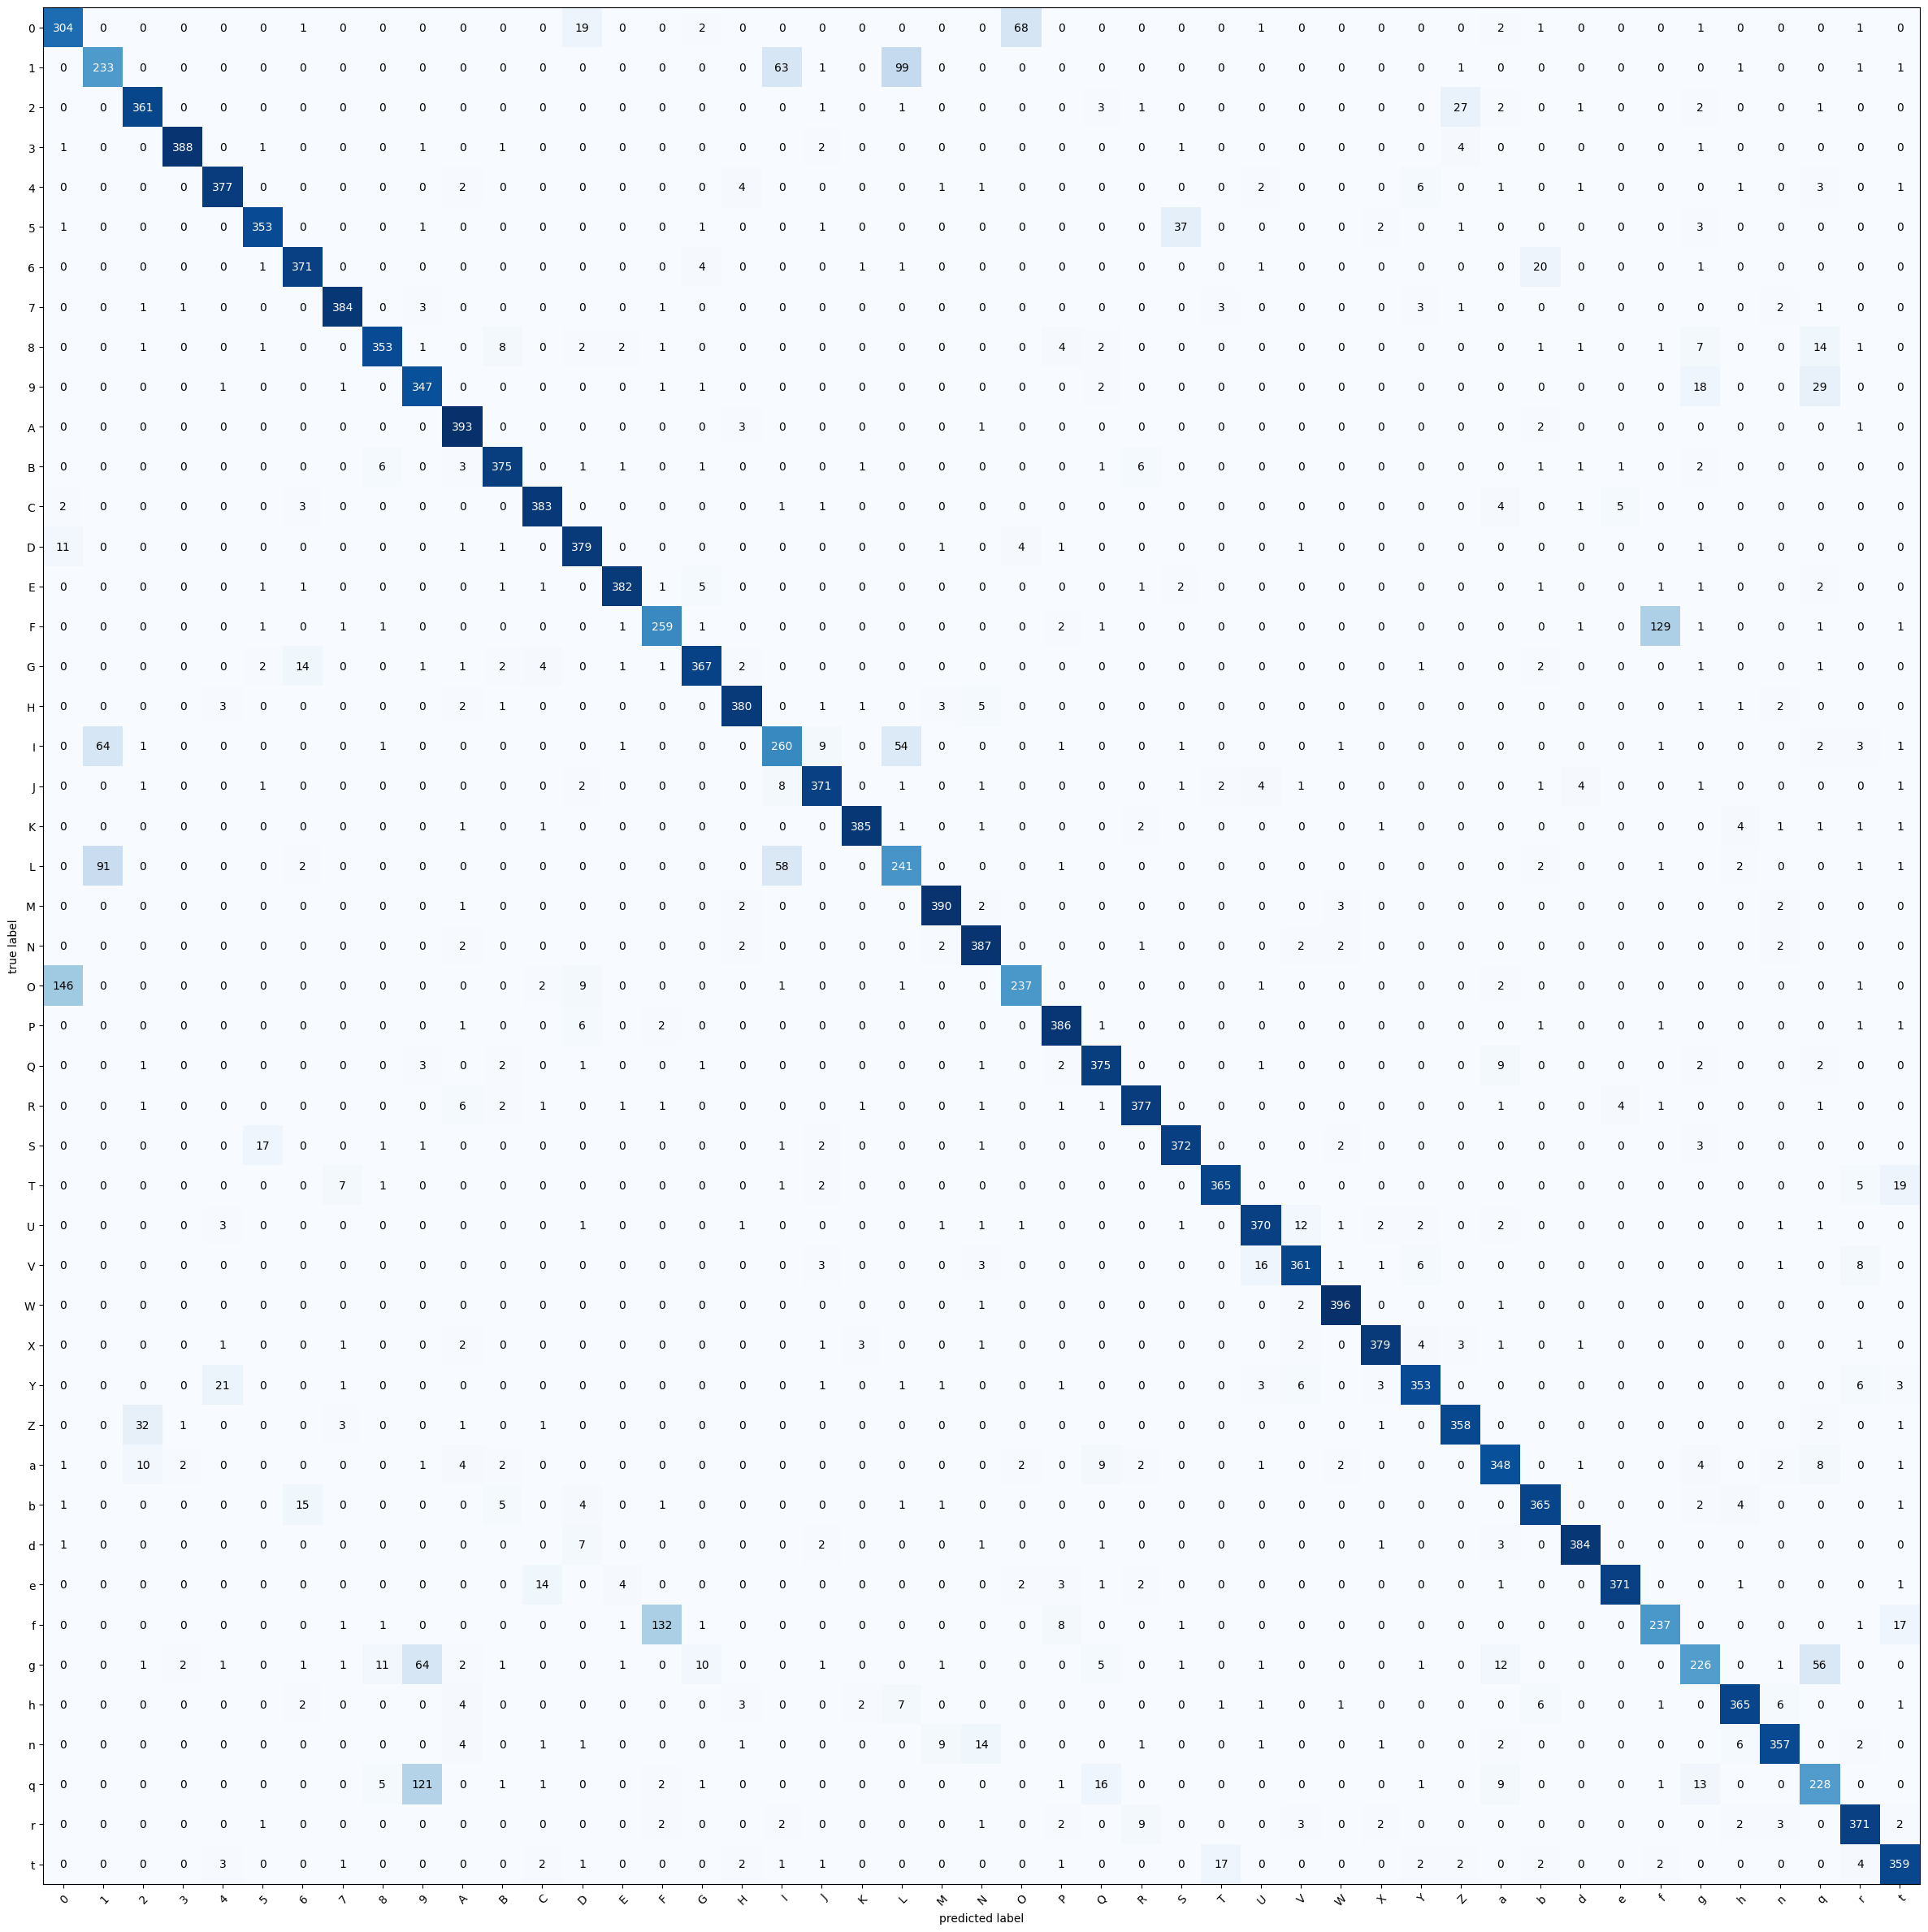

In [25]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets

all_targets = []
for _, label in test_data:
    all_targets.append(label)
all_targets = torch.tensor(all_targets)

# Ensure preds is a tensor
y_pred_tensor = torch.tensor(y_pred_tensor)
print(len(all_targets)/16)
# Setup the confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(labels_list), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=all_targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with NumPy
    class_names=labels_list,  # turn the row and column labels into class names
    figsize=(30, 30)
)

In [26]:
pytorch_total_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)
print(pytorch_total_params)

47359


In [ ]:
best_model